# **Step 1: Import Library**

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# **Step 2: Load Dataset**

In [50]:
df = pd.read_csv("../data/Books_rating.csv.zip", compression="zip")

df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [51]:
df.info()

print(f"Null rows:\n{df.isnull().sum()}")

print(f"Duplicated rows: {df.duplicated().sum()}")

print(f"Describe:\n{df.describe()}")

print(f"Number of unique users: {df["User_id"].nunique()}")
print(f"Number of unique books: {df["Id"].nunique()}")
print(f"Number of unique ratings: {df["review/score"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB
Null rows:
Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64
Duplicated rows: 8774
Describe:
               Price  review/score   review/time
count  481171.000000  

# **Step 3: Data Preprocessing**

## ***Filtering***

In [52]:
df_filter = df.rename(columns={"User_id": "UserID", "Id": "BookID", "review/score": "Rating"})

df_filter = df_filter[["BookID", "UserID", "Rating"]].dropna().drop_duplicates()

min_reviews = 5
max_reviews = 500

user_counts = df_filter["UserID"].value_counts()

df_filter = df_filter[df_filter["UserID"].map(user_counts).between(min_reviews, max_reviews)]

df_filter.head()

,BookID,UserID,Rating
1,0826414346,A30TK6U7DNS82R,5.0
3,0826414346,A2MVUWT453QH61,4.0
4,0826414346,A22X4XUPKF66MR,4.0
5,0826414346,A2F6NONFUDB6UK,4.0
11,0829814000,A373VVEU6Z9M0N,5.0


In [53]:
df_filter.info()

print(f"Null rows:\n{df_filter.isnull().sum()}")

print(f"Duplicated rows: {df_filter.duplicated().sum()}")

print(f"Describe:\n{df_filter.describe()}")

print(f"Number of unique users: {df_filter["UserID"].nunique()}")
print(f"Number of unique books: {df_filter["BookID"].nunique()}")
print(f"Number of unique ratings: {df_filter["Rating"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Index: 1084439 entries, 1 to 2999996
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   BookID  1084439 non-null  object 
 1   UserID  1084439 non-null  object 
 2   Rating  1084439 non-null  float64
dtypes: float64(1), object(2)
memory usage: 33.1+ MB
Null rows:
BookID    0
UserID    0
Rating    0
dtype: int64
Duplicated rows: 0
Describe:
             Rating
count  1.084439e+06
mean   4.234467e+00
std    1.104362e+00
min    1.000000e+00
25%    4.000000e+00
50%    5.000000e+00
75%    5.000000e+00
max    5.000000e+00
Number of unique users: 81666
Number of unique books: 127943
Number of unique ratings: 5


In [54]:
user_review_counts = df_filter["UserID"].value_counts()
user_review_counts_df = user_review_counts.reset_index()
user_review_counts_df.columns = ["UserID", "ReviewCount"]
user_review_counts_df.head()

,UserID,ReviewCount
0,A1L43KWWR05PCS,500
1,A2ODBHT4URXVXQ,489
2,A21NVBFIEQWDSG,486
3,AJQ1S39GZBKUG,480
4,AN8C7BGR98HLN,468


In [55]:
user_count = df_filter["UserID"].value_counts(ascending=True, normalize=True)
book_count = df_filter["BookID"].value_counts(ascending=True, normalize=True)
rating_count = df_filter["Rating"].value_counts(ascending=True, normalize=True)

print(user_count * 100)
print(book_count* 100)
print(rating_count * 100)

UserID
A2ZR969KVK6QTI    0.000461
A2Q543TN0328O1    0.000461
A1Q6IFD94I4LN7    0.000461
AF10IT6JETVJ7     0.000461
AX64AMAD1RTMI     0.000461
                    ...   
AN8C7BGR98HLN     0.043156
AJQ1S39GZBKUG     0.044263
A21NVBFIEQWDSG    0.044816
A2ODBHT4URXVXQ    0.045092
A1L43KWWR05PCS    0.046107
Name: proportion, Length: 81666, dtype: float64
BookID
1570981116    0.000092
1932360778    0.000092
069111496X    0.000092
1579122833    0.000092
0804815658    0.000092
                ...   
B000Q032UY    0.323762
B000NWQXBA    0.325975
B000PC54NG    0.326344
B000NWU3I4    0.327911
B000ILIJE0    0.328557
Name: proportion, Length: 127943, dtype: float64
Rating
1.0     4.545576
2.0     4.802483
3.0    10.325247
4.0    23.313068
5.0    57.013626
Name: proportion, dtype: float64


## ***Normalizing***

In [56]:
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

df_filter["UserID"] = user_encoder.fit_transform(df_filter["UserID"])
df_filter["BookID"] = book_encoder.fit_transform(df_filter["BookID"])

df_filter.head()

,BookID,UserID,Rating
1,44325,43601,5.0
3,44325,35211,4.0
4,44325,23259,4.0
5,44325,30608,4.0
11,44484,47383,5.0


In [57]:
probabilities = {
    1: 0.95,
    2: 0.9,
    3: 0.45,
    4: 0.18,
    5: 0.074
}

df_filter["Keep"] = df_filter["Rating"].apply(lambda x: np.random.rand() < probabilities[x])

df_balanced = df_filter[df_filter["Keep"]].drop(columns=["Keep"])

print(df_balanced["Rating"].value_counts(normalize=True))

user_counts = df_balanced["UserID"].value_counts()
print(user_counts.describe())

Rating
3.0    0.214932
2.0    0.199125
1.0    0.199053
5.0    0.194218
4.0    0.192672
Name: proportion, dtype: float64
count    60216.000000
mean         3.909343
std          6.131153
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        188.000000
Name: count, dtype: float64


In [58]:
print(df_balanced.info())
print(df_balanced.describe())
print(df_balanced.head())

print(f"Number of unique users: {df_balanced["UserID"].nunique()}")
print(f"Number of unique books: {df_balanced["BookID"].nunique()}")
print(f"Number of unique ratings: {df_balanced["Rating"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Index: 235405 entries, 4 to 2999975
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   BookID  235405 non-null  int32  
 1   UserID  235405 non-null  int32  
 2   Rating  235405 non-null  float64
dtypes: float64(1), int32(2)
memory usage: 5.4 MB
None
              BookID         UserID         Rating
count  235405.000000  235405.000000  235405.000000
mean    77651.893006   40948.182749       2.983879
std     37816.261417   23578.656676       1.401653
min         1.000000       0.000000       1.000000
25%     43330.000000   20341.000000       2.000000
50%     86130.000000   41011.000000       3.000000
75%    108950.000000   61320.000000       4.000000
max    127942.000000   81664.000000       5.000000
     BookID  UserID  Rating
4     44325   23259     4.0
61    46268   77592     2.0
66    52147   44945     5.0
79    97427   31996     5.0
174   95458   19558     2.0
Number of unique users

## ***Visualizing***

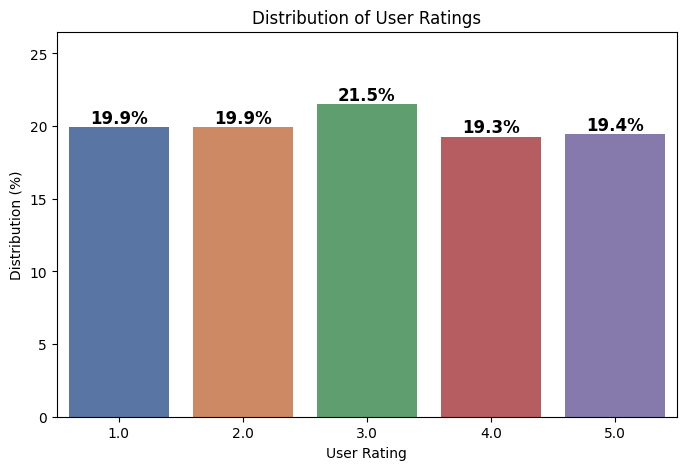

In [59]:
rating_counts = df_balanced["Rating"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.index, palette="deep", legend=False)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.xlabel("User Rating")
plt.ylabel("Distribution (%)")
plt.title("Distribution of User Ratings")
plt.ylim(0, max(rating_counts.values) + 5)

plt.savefig("../images/user_rating_distribution.png", dpi=300, facecolor="white", bbox_inches="tight", transparent=True)

plt.show()

# **Step 4: Train Model**

In [60]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_balanced[["UserID", "BookID", "Rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [61]:
from surprise.model_selection import GridSearchCV
from surprise import SVD

# Định nghĩa tham số cần tối ưu
param_grid = {
    "n_factors": [50, 100],
    "n_epochs": [20, 30],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.02, 0.05]
}

# Chạy Grid Search để tìm bộ tham số tốt nhất (bỏ verbose)
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
grid_search.fit(data)

# Kết quả
print("Best RMSE:", grid_search.best_score["rmse"])
print("Best Params:", grid_search.best_params["rmse"])

Best RMSE: 1.1144214396635375
Best Params: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02}


In [62]:
model = SVD(n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.02, random_state=42)

model.fit(trainset)

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)

RMSE: 1.0798


# **Step 5: Recommend Book**

In [65]:
def recommend_books(user_id, model, df, n=10):
    # Lấy danh sách tất cả sách
    all_books = df["BookID"].unique()
    
    # Lọc ra những sách mà user chưa đánh giá
    rated_books = df[df["UserID"] == user_id]["BookID"].values
    books_to_predict = [book for book in all_books if book not in rated_books]
    
    # Dự đoán rating cho từng sách chưa đọc
    predictions = [model.predict(user_id, book) for book in books_to_predict]
    
    # Sắp xếp theo rating dự đoán giảm dần
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Lấy top n sách gợi ý
    recommended_books = [pred.iid for pred in predictions[:n]]
    
    return recommended_books

In [66]:
user_id = "A1L43KWWR05PCS"  # Chọn một UserID có trong dataset
recommended_books = recommend_books(user_id, model, df_balanced)

print(f"Top 5 sách gợi ý cho user {user_id}: {recommended_books}")

Top 5 sách gợi ý cho user A1L43KWWR05PCS: [126554, 102850, 103929, 119347, 121131, 103936, 121112, 106321, 108581, 83173]
